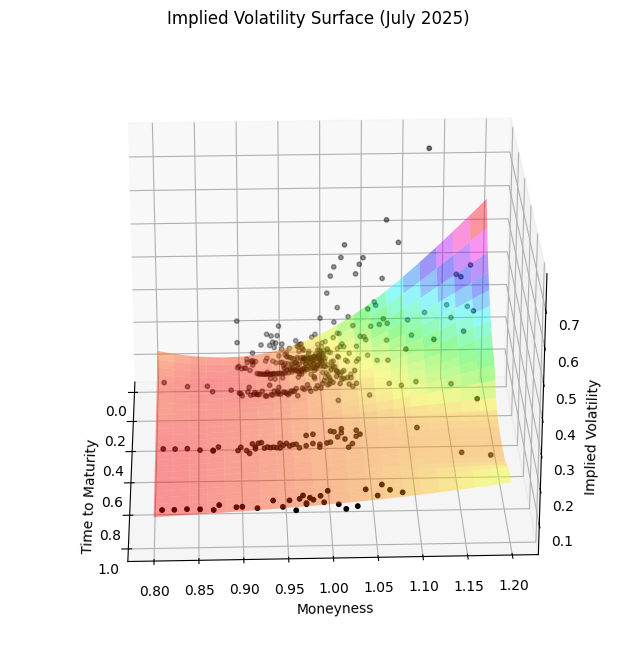

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import iqr
from scipy.linalg import inv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from py_vollib.black_scholes.implied_volatility import implied_volatility
from matplotlib import animation

# Check decimal separator, used comma here
df = pd.read_excel('/DAX_Data.xlsx')
df.columns = ['Price', 'Strike', 'Rate', 'TTM', 'OptionPrice', 'Class']
df['Moneyness'] = df['Price'] / df['Strike']

# Filter
df = df[(df['TTM'] <= 1) & (df['Moneyness'] >= 0.8) & (df['Moneyness'] <= 1.2)]

# Compute implied volatility
iv_list = []
for idx, row in df.iterrows():
    try:
        iv = implied_volatility(
            price=row['OptionPrice'],
            S=row['Price'],
            K=row['Strike'],
            t=row['TTM'],
            r=row['Rate'],
            flag='c' if row['Class'] == 1 else 'p'
        )
    except Exception:
        iv = np.nan
    iv_list.append(iv)

df['IV'] = iv_list
df = df.dropna(subset=['IV'])
df = df[(df['IV'] > 0.05) & (df['IV'] < 1.0)]

# Grid preparation
first_mon, last_mon = 0.8, 1.2
first_mat, last_mat = 0, 1
stepwidth_mon, stepwidth_mat = 0.02, 1/52

mon_grid = np.arange(first_mon, last_mon + stepwidth_mon, stepwidth_mon)
mat_grid = np.arange(first_mat, last_mat + stepwidth_mat, stepwidth_mat)
MON, MAT = np.meshgrid(mon_grid, mat_grid)

# Smoothing using Nadaraya-Watson Kernel Estimation
gmat, gmon = MAT.shape
iv_surf = np.zeros((gmat, gmon))

moneyness_array = df['Moneyness'].values
ttm_array = df['TTM'].values
iv_array = df['IV'].values
n = len(df)

#set bandwith
h1 = 0.1
h2 = 0.1

for j in range(gmat):
    for k in range(gmon):
        X = np.column_stack((
            np.ones(n),
            moneyness_array - MON[j, k],
            ttm_array - MAT[j, k]
        ))

        u1 = (moneyness_array - MON[j, k]) / h1
        u2 = (ttm_array - MAT[j, k]) / h2
        weights = (np.exp(-0.5 * u1 ** 2) / np.sqrt(2 * np.pi)) * (np.exp(-0.5 * u2 ** 2) / np.sqrt(2 * np.pi))
        W = np.diag(weights)

        try:
            est = inv(X.T @ W @ X) @ X.T @ W @ iv_array
            iv_surf[j, k] = est[0]
        except np.linalg.LinAlgError:
            iv_surf[j, k] = np.nan

# Plot and animate
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(
    MAT, MON, iv_surf,
    cmap='hsv', alpha=0.4, edgecolor='none'
)

# Scatter actual points
ax.scatter(
    df['TTM'], df['Moneyness'], df['IV'],
    color='black', s=10, label='Observed IV'
)

ax.set_xlabel('Time to Maturity')
ax.set_ylabel('Moneyness')
ax.set_zlabel('Implied Volatility')
ax.set_title('Implied Volatility Surface (July 2025)')

def rotate(angle):
    ax.view_init(elev=25, azim=angle)

# Create animation
rot_animation = animation.FuncAnimation(
    fig, rotate, frames=np.arange(0, 360, 2), interval=100
)

rot_animation.save('IV_Surface_Rotation.gif', dpi=100, writer='pillow')

plt.show()
